# RNN Classification Test
Trying to classify the age of an author based on a written blogpost

## 1. Import libraries

In [1]:
!pip install torchtext==0.4

In [2]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import re
import os
import time

import torch
import torchtext
from torchtext.datasets import text_classification
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data.dataset import random_split
import nltk
import plotly.express as px
from nltk.stem import WordNetLemmatizer
import plotly.graph_objs as go
nltk.download('wordnet')
nltk.download('stopwords')

from collections import defaultdict, OrderedDict, Counter
import operator

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## 2. Load and preprocces the dataframe

In [3]:
df = pd.read_csv('/content/drive/MyDrive/Language, speech and dialogue processing/Datasets/df_pan_train.csv') 
df = df.drop(['Unnamed: 0', 'lang', 'id'], axis=1)

In [4]:
df = df.groupby('gender').apply(lambda x: x.sample(frac=0.4))

In [5]:
df

age_group  ...                                               text
gender                   ...                                                   
female 400190       10s  ...          guess what ive broke my arm i look stupid
       184356       30s  ...  As we all know lookup motor optimization is a ...
       351209       30s  ...  <span class="textAlign textAlignCenter">;<img ...
       277411       20s  ...  Saturday is a special day for my life.plz pray...
       362293       20s  ...  If you want to develop, develop others.\n<br /...
...                 ...  ...                                                ...
male   217987       30s  ...  Horrible ink concoctions , like Styrofoam cup ...
       230526       30s  ...  <span class="textAlign textAlignCenter">;\n<br...
       187906       20s  ...  DETROIT -- Typically the Detroit White Wings b...
       289060       30s  ...  It is with the blessings and help of Philips S...
       74985        20s  ...  Iam so happy bcos the agony of our saviour lor...

[160797 rows x 3 columns]

In [6]:
fm = df["gender"].unique().tolist()
fm.sort()
fm_dict = {}
for gender in fm:
  fm_dict[gender] = df.loc[df['gender'] == gender]

for key, value in fm_dict.items():
  fm_dict[key] = value
  
print(fm_dict)

{'female':               age_group  ...                                               text
gender                   ...                                                   
female 400190       10s  ...          guess what ive broke my arm i look stupid
       184356       30s  ...  As we all know lookup motor optimization is a ...
       351209       30s  ...  <span class="textAlign textAlignCenter">;<img ...
       277411       20s  ...  Saturday is a special day for my life.plz pray...
       362293       20s  ...  If you want to develop, develop others.\n<br /...
...                 ...  ...                                                ...
       336300       20s  ...  <img src="<a href="http://en.pan.netcom/go/out...
       224552       20s  ...  capsules, thousands and thousands of guys have...
       39865        30s  ...  <a href="http://en.pan.netcom/go/out/url=-aHR0...
       320780       30s  ...  The article below the source is from The Provi...
       288174       30s  ... 

In [7]:
dataframes_f = []
dataframes_m = []

for key, value in fm_dict.items():
  if key == 'female':
    dataframes_f.append(value)
  elif key == 'male':
    dataframes_m.append(value)


df_f = pd.concat(dataframes_f)
df_m = pd.concat(dataframes_m)


all_dataframes = [df_f, df_m]

min_len = len(all_dataframes[0])

for df in all_dataframes:
  if len(df) < min_len:
    min_len = len(df)

df_f["gen"] = 0
df_m["gen"] = 1


all_dataframes = [df_f.sample(min_len), df_m.sample(min_len)]

df = pd.concat(all_dataframes)

## 3. Create n_grams from the text (Optional)

In [8]:
# lemmatizing function
def lemmatize(text):
    lemmatizer = WordNetLemmatizer()
    text = [lemmatizer.lemmatize(word) for word in text]
    return text

# remove stopwords
def remove_stopwords(text):
    stopword = nltk.corpus.stopwords.words('english')
    text = [word for word in text if word not in stopword]
    return text
    
def tokenize(text):
    wrong_words = ["urllink", "nbsp"]
    tokens = [token for token in text.split(" ") if token != "" and token not in wrong_words]
    return tokens

def lowered(s):
    return s.lower()

def remove_nonalph(s):
      s = re.sub(r'[^a-zA-Z0-9\s]', ' ', s)
      return s

def generate_ngrams(s, n):
    # Use the zip function to help us generate n-grams
    # Concatentate the tokens into ngrams and return
    ngrams = zip(*[s[i:] for i in range(n)])
    return [" ".join(ngram) for ngram in ngrams]

In [9]:
df["text"] = df["text"].apply(lowered).apply(remove_nonalph).apply(tokenize)


# ngram = 2
# for i, text in enumerate(df['text']):
#   if type(df['text'].iloc[i]) != list:
#     lower = lowered(text)
#     non_alph = remove_nonalph(lower)
#     tokens = tokenize(non_alph)
#     # no_stopwords = remove_stopwords(tokens)
#     # lemma = lemmatize(no_stopwords)
#     # ngrams = generate_ngrams(lemma, ngram)
#     df['text'].iloc[i] = tokens
print(df['text'].iloc[0])
print(df['text'])

['some', 'men', 'and', 'women', 'think', 'it', 'is', 'a', 'web', 'site', 'attempting', 'to', 'look', 'additional', 'official', 'but', 'in', 'reality', 'a', 'site', 'seal', 'can', 'suggest', 'a', 'great', 'deal', 'far', 'more', 'than', 'just', 'the', 'physical', 'appearance', 'of', 'the', 'site', 'seeking', 'official', 'in', 'truth', 'it', 's', 'essentially', 'a', 'third', 'party', 'seal', 'letting', 'other', 'individuals', 'know', 'that', 'a', 'web', 'page', 'is', 'secure', 'br', 'br', 'the', 'first', 'issue', 'a', 'internet', 'site', 'wants', 'to', 'identify', 'is', 'if', 'it', 'have', 'to', 'have', 'a', 'web', 'site', 'seal', 'if', 'the', 'web', 'site', 'is', 'accomplishing', 'small', 'business', 'the', 'place', 'personalized', 'info', 'is', 'becoming', 'sent', 'back', 'and', 'forth', 'then', 'it', 'is', 'critical', 'to', 'make', 'certain', 'that', 'a', 'secure', 'seal', 'or', 'privacy', 'seal', 'be', 'obtained', 'this', 'protects', 'not', 'only', 'the', 'web', 'site', 'but', 'it', '

In [10]:
df.index = range(len(df))

In [11]:
df

,age_group,gender,text,gen
0,30s,female,"[some, men, and, women, think, it, is, a, web,...",0
1,10s,female,"[weblog, advertising, is, probably, the, most,...",0
2,30s,female,"[from, the, time, the, world, wide, web, becam...",0
3,20s,female,"[so, various, folks, now, a, days, are, strugg...",0
4,10s,female,"[molecular, biologists, know, that, what, help...",0
...,...,...,...,...
159077,20s,male,"[from, simple, family, offers, to, superior, m...",1
159078,20s,male,"[i, would, like, to, know, all, the, members, ...",1
159079,10s,male,"[bump, the, automobile, and, observe, the, len...",1
159080,30s,male,"[a, href, http, en, pan, netcom, go, out, url,...",1


Pre processing data loader

In [12]:
class_choice = 'gen'
classdict = defaultdict(int)

for row in df[class_choice]:
  classdict[row] += 1
print(sorted(classdict))

### PROBLEM: ALS IK DIT WISSEL NAAR NORMAL SORT DAN IS DE UITKOMST INEENS ANDERS???
classdict = dict(sorted(classdict.items(), key=operator.itemgetter(1), reverse=True))
#classdict = dict(sorted(classdict.items()))
print('classdict:')
print(classdict)

[0, 1]
classdict:
{0: 79541, 1: 79541}


## 7. Vocabulary dictionary
Making a dict of all the words in the dataset and mapping each unique word to a unique number

In [13]:
vocabdict = defaultdict(int)   

for row in df['text']:
  for n_gram in row:
    n_gram = n_gram.lower()
    vocabdict[n_gram] += 1

vocabdict = dict(sorted(vocabdict.items(), key=operator.itemgetter(1), reverse=True))
print(vocabdict)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [14]:
# WORD TO NUMBER MAPPING
l = list(vocabdict.keys())
wordmap = dict([(y,x) for x,y in enumerate(l)])
print(wordmap)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



## 8. Mapping text column to numbers (tensor)

In [15]:
import numpy as np
text_int_list = []
text_lengths = []
for i, text in enumerate(df['text']):
  newtext = []
  lens = []
  for word in text:
    newtext.append(int(wordmap[word]))
  text_lengths.append(len(newtext))
  text_int_list.append(newtext)
average_len = int(sum(text_lengths) / len(text_lengths))
df["lengths"] = text_lengths

encoding_padded = []
for ints in text_int_list:
  N = average_len
  zeros = np.zeros(N, dtype=int)
  encoded = zeros
  length = min(N, len(ints))
  encoded[:length] = ints[:length]
  encoding_padded.append(np.array((encoded, len(ints))))

df["encoded"] = encoding_padded
df



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



,age_group,gender,text,gen,lengths,encoded
0,30s,female,"[some, men, and, women, think, it, is, a, web,...",0,613,"[[65, 274, 5, 216, 230, 13, 7, 1, 111, 128, 25..."
1,10s,female,"[weblog, advertising, is, probably, the, most,...",0,938,"[[3999, 393, 7, 358, 0, 69, 1427, 3086, 4, 393..."
2,30s,female,"[from, the, time, the, world, wide, web, becam...",0,613,"[[37, 0, 60, 0, 192, 441, 111, 2152, 8, 2076, ..."
3,20s,female,"[so, various, folks, now, a, days, are, strugg...",0,851,"[[57, 303, 404, 119, 1, 325, 12, 3600, 37, 255..."
4,10s,female,"[molecular, biologists, know, that, what, help...",0,822,"[[11997, 49389, 114, 9, 64, 778, 59, 0, 1714, ..."
...,...,...,...,...,...,...
159077,20s,male,"[from, simple, family, offers, to, superior, m...",1,596,"[[37, 296, 346, 456, 2, 960, 1403, 5, 828, 143..."
159078,20s,male,"[i, would, like, to, know, all, the, members, ...",1,59,"[[43, 98, 73, 2, 114, 42, 0, 831, 4, 28, 37, 4..."
159079,10s,male,"[bump, the, automobile, and, observe, the, len...",1,594,"[[10374, 0, 976, 5, 1641, 0, 1646, 4, 60, 13, ..."
159080,30s,male,"[a, href, http, en, pan, netcom, go, out, url,...",1,528,"[[1, 26, 15, 30, 28, 33, 25, 18, 27, 575110, 2..."


In [16]:
X = list(df['encoded'])
y = list(df['gen'])
print(X[0])
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2)

[array([   65,   274,     5,   216,   230,    13,     7,     1,   111,
         128,  2520,     2,   133,   279,  2544,    56,     8,  1217,
           1,   128,  5137,    19,  1974,     1,   118,   263,   221,
          44,    96,    63,     0,   821,  1319,     4,     0,   128,
        1260,  2544,     8,   955,    13,    34,  1638,     1,  1800,
        1059,  5137,  3964,    75,   209,   114,     9,     1,   111,
         370,     7,  1199,     3,     3,     0,   151,   551,     1,
         120,   128,  1141,     2,  1460,     7,    35,    13,    23,
           2,    23,     1,   111,   128,  5137,    35,     0,   111,
         128,     7,  6183,   255,   108,     0,   158,  2365,   529,
           7,   764,  2329,   173,     5,  2305,    97,    13,     7,
         850,     2,    59,   284,     9,     1,  1199,  5137,    24,
        3709,  5137,    14,  1877,    21,  6840,    32,   102,     0,
         111,   128,    56,    13,  6840,     0,   274,     5,   216,
           9,    12

In [17]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import re
import spacy
from collections import Counter
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import string
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from sklearn.metrics import mean_squared_error
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [18]:
class BlogDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.y = Y
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return torch.from_numpy(self.X[idx][0].astype(np.int32)), self.y[idx], self.X[idx][1]

In [19]:
train_ds = BlogDataset(X_train, y_train)
valid_ds = BlogDataset(X_valid, y_valid)

**TO-DO:**

*   Confusion matrix
*   Activation words





In [20]:

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# confusion matrix plot function
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.savefig('/content/drive/MyDrive/Language, speech and dialogue processing/gender_PAN_rnn_confusion_matrix.png')
    


In [21]:
def train_model(model, epochs=10, lr=0.001):
    parameters = filter(lambda p: p.requires_grad, model.parameters())
    optimizer = torch.optim.Adam(parameters, lr=lr)
    for i in range(epochs):
        model.train()
        sum_loss = 0.0
        total = 0
        for x, y, l in train_dl:
            x = x.long().to(device)
            y = y.long().to(device)
            l = l.to(device)
            y_pred = model(x, l)
            optimizer.zero_grad()
            x, y, l = x.to(device), y.to(device), l.to(device)
            loss = F.cross_entropy(y_pred, y).to(device)
            loss.backward()
            optimizer.step()
            sum_loss += loss.item()*y.shape[0]
            total += y.shape[0]
        val_loss, val_acc, val_rmse = validation_metrics(model, val_dl)
        train_loss = sum_loss/total
        print('Epoch: %d' %(i + 1))
        print(f'\tLoss: {train_loss:.4f}(train)\t')
        print(f'\tLoss: {val_loss:.4f}(valid)\t|\tAcc: {val_acc * 100:.1f}%(valid) | \tRMSE: {val_rmse * 100:.1f}(valid)')
        if i == (epochs-1):
          predictions, labels = validation_metrics(model, val_dl, True)
          conf_matrix = confusion_matrix(np.array(labels), np.array(predictions), labels=[0, 1])
          np.set_printoptions(precision=2)
          # Plot non-normalized confusion matrix
          #plt.figure()
          plot_confusion_matrix(conf_matrix, classes=['female','male'], normalize=True, title='gender PAN13 RNN Confusion matrix, with normalization')




def validation_metrics (model, valid_dl, last_epoch=False):
    model.eval()
    correct = 0
    total = 0
    sum_loss = 0.0
    sum_rmse = 0.0
    predictions = []
    labels = []
    for x, y, l in valid_dl:
        x,y,l = x.to(device), y.to(device), l.to(device)
        x = x.long()
        y = y.long()
        y_hat = model(x, l)
        loss = F.cross_entropy(y_hat, y)
        pred = y_hat.argmax(1)
        predict = pred.to('cpu')
        label = y.to('cpu')
        predictions.extend(predict)
        labels.extend(label)
        correct += (pred == y).float().sum()
        total += y.shape[0]
        sum_loss += loss.item()*y.shape[0]
        sum_rmse += np.sqrt(mean_squared_error(pred.cpu(), y.unsqueeze(-1).cpu()))*y.shape[0]
    if last_epoch == False:
      return sum_loss/total, correct/total, sum_rmse/total
    else:
      return predictions, labels



In [22]:
batch_size = 256
vocab_size = len(vocabdict)
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_dl = DataLoader(valid_ds, batch_size=batch_size)

In [23]:
class LSTM_fixed_len(torch.nn.Module) :
    def __init__(self, vocab_size, embedding_dim, hidden_dim) :
        super().__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, 5)
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, x, l):
        x = self.embeddings(x)
        x = self.dropout(x)
        lstm_out, (ht, ct) = self.lstm(x)
        return self.linear(ht[-1])

In [24]:
print(f"Vocab size: {vocab_size}")

# Rule of thumb voor embed dim volgens: 
# (https://datascience.stackexchange.com/questions/31109/ratio-between-embedded-vector-dimensions-and-vocabulary-size)

embedding_dimensions =  int(vocab_size**0.25)

model_fixed =  LSTM_fixed_len(vocab_size, embedding_dimensions, 50).to(device)

Vocab size: 575121


Epoch: 1
	Loss: 0.6981(train)	
	Loss: 0.6815(valid)	|	Acc: 57.4%(valid) | 	RMSE: 65.3(valid)
Epoch: 2
	Loss: 0.6734(train)	
	Loss: 0.6715(valid)	|	Acc: 58.7%(valid) | 	RMSE: 64.2(valid)
Epoch: 3
	Loss: 0.6298(train)	
	Loss: 0.6643(valid)	|	Acc: 61.1%(valid) | 	RMSE: 62.3(valid)
Epoch: 4
	Loss: 0.5231(train)	
	Loss: 0.7078(valid)	|	Acc: 61.3%(valid) | 	RMSE: 62.1(valid)
Epoch: 5
	Loss: 0.4075(train)	
	Loss: 0.7627(valid)	|	Acc: 61.9%(valid) | 	RMSE: 61.7(valid)
Epoch: 6
	Loss: 0.3283(train)	
	Loss: 0.8691(valid)	|	Acc: 62.3%(valid) | 	RMSE: 61.4(valid)
Epoch: 7
	Loss: 0.2751(train)	
	Loss: 0.8923(valid)	|	Acc: 62.0%(valid) | 	RMSE: 61.6(valid)
Epoch: 8
	Loss: 0.2358(train)	
	Loss: 1.0248(valid)	|	Acc: 62.3%(valid) | 	RMSE: 61.3(valid)
Epoch: 9
	Loss: 0.2079(train)	
	Loss: 1.0548(valid)	|	Acc: 62.5%(valid) | 	RMSE: 61.1(valid)
Epoch: 10
	Loss: 0.1859(train)	
	Loss: 1.1665(valid)	|	Acc: 62.2%(valid) | 	RMSE: 61.5(valid)
Epoch: 11
	Loss: 0.1674(train)	
	Loss: 1.2174(valid)	|	Acc: 62.5%(val

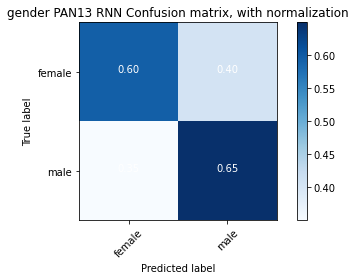

In [25]:
train_model(model_fixed, epochs=30, lr=0.01)